### E01. Add DEM LAYERS to all MODIS EOPatches - needed for final result calculation

0. Load required libraries, site dependant constants and utility functions.
2. Create EOTasks
3. Create and execute EOWorkflow

#### 0. Load required libraries, site dependant constants and utility functions.

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
import datetime

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

In [3]:
LANDSAT_PRODUCT =  site.DATA_PRODUCTS[1]
print(LANDSAT_PRODUCT)
MODIS_PRODUCT = site.DATA_PRODUCTS[0]
print(MODIS_PRODUCT)
LANDSAT_DATE_RANGE = site.DATE_RANGES_LANDSAT_8[0]
print(LANDSAT_DATE_RANGE)
MODIS_DATE_RANGE = site.DATE_RANGES_MODIS[0]
print(MODIS_DATE_RANGE)

LANDSAT_8
MODIS
('2013-05-01', '2013-10-31')
('2013-04-26', '2013-11-05')


In [4]:
exemplary_landsat = EOPatch.load(io_utils.get_eopatches_dir(LANDSAT_PRODUCT, site.SITE_NAME, site.AVAILABLE_CRSs[0], LANDSAT_DATE_RANGE)+'2969_maxcc_0.05_x-3_y-130')
exemplary_modis = EOPatch.load(io_utils.get_eopatches_dir(MODIS_PRODUCT, site.SITE_NAME, site.AVAILABLE_CRSs[0], MODIS_DATE_RANGE)+'2969_maxcc_0.05_x-3_y-130')

In [5]:
exemplary_landsat

EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2: numpy.ndarray(shape=(7, 333, 333, 11), dtype=float32)
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(7, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 11), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS_DAY_0: numpy.ndarray(shape

In [6]:
exemplary_modis

EOPatch(
  data: {
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 7), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 3
    index_y: 130
    maxcc: '0.05'
    patch_index: 2969
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2013-04-26', '2013-11-05')
  }
  bbox: BBox(((400000.0, 8030000.0), (410000.0, 8040000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2013, 4, 26, 12, 0), ..., datetime.datetime(2013, 11, 5, 12, 0

#### 1. Create EOTasks:

In [24]:
# define second merge task for masks:

class AppendCorrespondingDataTimeless(EOTask):   
    """
    The task extracts one layer from data of one eopatch and appends it on the other eopatch
    """
    def __init__(self, exported_feature_name, new_feature_name ):
        self.exported_feature_name = exported_feature_name
        self.new_feature_name = new_feature_name
        
    def execute(self, eopatch, second_eopatch ):
        
        # extract mask:
        extracted_mask = second_eopatch.data_timeless[self.exported_feature_name]
        #print(extracted_mask.shape)
        # append data:add_feature(FeatureType.DATA, 'MODIS_RAW_DAY_0', data)
        eopatch.add_feature(FeatureType.DATA_TIMELESS, self.new_feature_name, extracted_mask)
        
        return eopatch

In [25]:
append_data_dem_raw = AppendCorrespondingDataTimeless('DEM_RAW_LAYER', 'DEM_RAW_LAYER')
append_data_slope  = AppendCorrespondingDataTimeless('DEM_SLOPE_LAYER', 'DEM_SLOPE_LAYER')

#### 2. Create and execute EOWorkflow

In [26]:
# define a function to chunk the indexes, when applysing all at once, there are problems.
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [27]:
[print(i)for i in range(7) ]

0
1
2
3
4
5
6


[None, None, None, None, None, None, None]

In [28]:
date_ranges_tuple = [(site.DATE_RANGES_LANDSAT_8[i],site.DATE_RANGES_MODIS[i] )for i in range(7)]

In [29]:
date_ranges_tuple

[(('2013-05-01', '2013-10-31'), ('2013-04-26', '2013-11-05')),
 (('2014-05-01', '2014-10-31'), ('2014-04-26', '2014-11-05')),
 (('2015-05-01', '2015-10-31'), ('2015-04-26', '2015-11-05')),
 (('2016-05-01', '2016-10-31'), ('2016-04-26', '2016-11-05')),
 (('2017-05-01', '2017-10-31'), ('2017-04-26', '2017-11-05')),
 (('2018-05-01', '2018-10-31'), ('2018-04-26', '2018-11-05')),
 (('2019-05-01', '2019-10-31'), ('2019-04-26', '2019-11-05'))]

In [43]:
# run workflow
for date_ranges in date_ranges_tuple:
    print('Reading EOPatches from:', date_ranges[0] )
    modis_eopatches_filepath = io_utils.get_eopatches_dir(MODIS_PRODUCT, site.SITE_NAME, site.AVAILABLE_CRSs[0], date_ranges[1])
    landsat_eopatches_filepath = io_utils.get_eopatches_dir(LANDSAT_PRODUCT, site.SITE_NAME, site.AVAILABLE_CRSs[0], date_ranges[0])
    # TASK TO LOAD AND SAVE EXISTING EOPATCHES HAS TO BE CREATED YEARLY (different directories)
    load_eotask = LoadTask(modis_eopatches_filepath)
    save_eotask = SaveTask(modis_eopatches_filepath, overwrite_permission=OverwritePermission.OVERWRITE_PATCH, compress_level=1)
    
    # Define the workflow
    workflow = LinearWorkflow(
    load_eotask,
    append_data_dem_raw,
    append_data_slope,  
    save_eotask
    )
                      
    list_of_available_patches = io_utils.get_list_of_eopatches(modis_eopatches_filepath)
    list_in_chunks = chunkIt(list_of_available_patches, 5 )
    for element in list_in_chunks:
        print('Doing now following indexes:', element )
        execution_args = []
        for eopatch_name in element:
            print('currently_loaded',eopatch_name)
            landsat_eo_patch = EOPatch.load(landsat_eopatches_filepath+eopatch_name)
            execution_args.append({
            load_eotask:                    {'eopatch_folder': eopatch_name},
            append_data_dem_raw:            {'second_eopatch': landsat_eo_patch},
            append_data_slope:              {'second_eopatch': landsat_eo_patch},
            save_eotask:                    {'eopatch_folder': eopatch_name}
            })
            #del modis_eo_patch
                                       
        executor = EOExecutor(workflow, execution_args, save_logs=True)
        executor.run(workers=1, multiprocess=False)

        executor.make_report()
        

Reading EOPatches from: ('2013-05-01', '2013-10-31')
Doing now following indexes: ['2969_maxcc_0.05_x-3_y-130', '2970_maxcc_0.05_x-3_y-131', '2971_maxcc_0.05_x-3_y-132', '2972_maxcc_0.05_x-3_y-133', '2973_maxcc_0.05_x-3_y-134', '2974_maxcc_0.05_x-3_y-135', '2975_maxcc_0.05_x-3_y-136', '2976_maxcc_0.05_x-3_y-137', '2977_maxcc_0.05_x-3_y-138', '2978_maxcc_0.05_x-3_y-139', '2979_maxcc_0.05_x-3_y-140']
currently_loaded 2969_maxcc_0.05_x-3_y-130
currently_loaded 2970_maxcc_0.05_x-3_y-131
currently_loaded 2971_maxcc_0.05_x-3_y-132
currently_loaded 2972_maxcc_0.05_x-3_y-133
currently_loaded 2973_maxcc_0.05_x-3_y-134
currently_loaded 2974_maxcc_0.05_x-3_y-135
currently_loaded 2975_maxcc_0.05_x-3_y-136
currently_loaded 2976_maxcc_0.05_x-3_y-137
currently_loaded 2977_maxcc_0.05_x-3_y-138
currently_loaded 2978_maxcc_0.05_x-3_y-139
currently_loaded 2979_maxcc_0.05_x-3_y-140



Doing now following indexes: ['3059_maxcc_0.05_x-4_y-130', '3060_maxcc_0.05_x-4_y-131', '3061_maxcc_0.05_x-4_y-132', '3062_maxcc_0.05_x-4_y-133', '3063_maxcc_0.05_x-4_y-134', '3064_maxcc_0.05_x-4_y-135', '3065_maxcc_0.05_x-4_y-136', '3066_maxcc_0.05_x-4_y-137', '3067_maxcc_0.05_x-4_y-138', '3068_maxcc_0.05_x-4_y-139', '3069_maxcc_0.05_x-4_y-140']
currently_loaded 3059_maxcc_0.05_x-4_y-130
currently_loaded 3060_maxcc_0.05_x-4_y-131
currently_loaded 3061_maxcc_0.05_x-4_y-132
currently_loaded 3062_maxcc_0.05_x-4_y-133
currently_loaded 3063_maxcc_0.05_x-4_y-134
currently_loaded 3064_maxcc_0.05_x-4_y-135
currently_loaded 3065_maxcc_0.05_x-4_y-136
currently_loaded 3066_maxcc_0.05_x-4_y-137
currently_loaded 3067_maxcc_0.05_x-4_y-138
currently_loaded 3068_maxcc_0.05_x-4_y-139
currently_loaded 3069_maxcc_0.05_x-4_y-140



Doing now following indexes: ['3172_maxcc_0.05_x-5_y-130', '3173_maxcc_0.05_x-5_y-131', '3174_maxcc_0.05_x-5_y-132', '3175_maxcc_0.05_x-5_y-133', '3176_maxcc_0.05_x-5_y-134', '3177_maxcc_0.05_x-5_y-135', '3178_maxcc_0.05_x-5_y-136', '3179_maxcc_0.05_x-5_y-137', '3180_maxcc_0.05_x-5_y-138', '3181_maxcc_0.05_x-5_y-139', '3182_maxcc_0.05_x-5_y-140']
currently_loaded 3172_maxcc_0.05_x-5_y-130
currently_loaded 3173_maxcc_0.05_x-5_y-131
currently_loaded 3174_maxcc_0.05_x-5_y-132
currently_loaded 3175_maxcc_0.05_x-5_y-133
currently_loaded 3176_maxcc_0.05_x-5_y-134
currently_loaded 3177_maxcc_0.05_x-5_y-135
currently_loaded 3178_maxcc_0.05_x-5_y-136
currently_loaded 3179_maxcc_0.05_x-5_y-137
currently_loaded 3180_maxcc_0.05_x-5_y-138
currently_loaded 3181_maxcc_0.05_x-5_y-139
currently_loaded 3182_maxcc_0.05_x-5_y-140



Doing now following indexes: ['3306_maxcc_0.05_x-6_y-130', '3307_maxcc_0.05_x-6_y-131', '3308_maxcc_0.05_x-6_y-132', '3309_maxcc_0.05_x-6_y-133', '3310_maxcc_0.05_x-6_y-134', '3311_maxcc_0.05_x-6_y-135', '3312_maxcc_0.05_x-6_y-136', '3313_maxcc_0.05_x-6_y-137', '3314_maxcc_0.05_x-6_y-138', '3315_maxcc_0.05_x-6_y-139', '3316_maxcc_0.05_x-6_y-140']
currently_loaded 3306_maxcc_0.05_x-6_y-130
currently_loaded 3307_maxcc_0.05_x-6_y-131
currently_loaded 3308_maxcc_0.05_x-6_y-132
currently_loaded 3309_maxcc_0.05_x-6_y-133
currently_loaded 3310_maxcc_0.05_x-6_y-134
currently_loaded 3311_maxcc_0.05_x-6_y-135
currently_loaded 3312_maxcc_0.05_x-6_y-136
currently_loaded 3313_maxcc_0.05_x-6_y-137
currently_loaded 3314_maxcc_0.05_x-6_y-138
currently_loaded 3315_maxcc_0.05_x-6_y-139
currently_loaded 3316_maxcc_0.05_x-6_y-140



Doing now following indexes: ['3469_maxcc_0.05_x-7_y-130', '3470_maxcc_0.05_x-7_y-131', '3471_maxcc_0.05_x-7_y-132', '3472_maxcc_0.05_x-7_y-133', '3473_maxcc_0.05_x-7_y-134', '3474_maxcc_0.05_x-7_y-135', '3475_maxcc_0.05_x-7_y-136', '3476_maxcc_0.05_x-7_y-137', '3477_maxcc_0.05_x-7_y-138', '3478_maxcc_0.05_x-7_y-139', '3479_maxcc_0.05_x-7_y-140']
currently_loaded 3469_maxcc_0.05_x-7_y-130
currently_loaded 3470_maxcc_0.05_x-7_y-131
currently_loaded 3471_maxcc_0.05_x-7_y-132
currently_loaded 3472_maxcc_0.05_x-7_y-133
currently_loaded 3473_maxcc_0.05_x-7_y-134
currently_loaded 3474_maxcc_0.05_x-7_y-135
currently_loaded 3475_maxcc_0.05_x-7_y-136
currently_loaded 3476_maxcc_0.05_x-7_y-137
currently_loaded 3477_maxcc_0.05_x-7_y-138
currently_loaded 3478_maxcc_0.05_x-7_y-139
currently_loaded 3479_maxcc_0.05_x-7_y-140



Reading EOPatches from: ('2014-05-01', '2014-10-31')
Doing now following indexes: ['2969_maxcc_0.05_x-3_y-130', '2970_maxcc_0.05_x-3_y-131', '2971_maxcc_0.05_x-3_y-132', '2972_maxcc_0.05_x-3_y-133', '2973_maxcc_0.05_x-3_y-134', '2974_maxcc_0.05_x-3_y-135', '2975_maxcc_0.05_x-3_y-136', '2976_maxcc_0.05_x-3_y-137', '2977_maxcc_0.05_x-3_y-138', '2978_maxcc_0.05_x-3_y-139', '2979_maxcc_0.05_x-3_y-140']
currently_loaded 2969_maxcc_0.05_x-3_y-130
currently_loaded 2970_maxcc_0.05_x-3_y-131
currently_loaded 2971_maxcc_0.05_x-3_y-132
currently_loaded 2972_maxcc_0.05_x-3_y-133
currently_loaded 2973_maxcc_0.05_x-3_y-134
currently_loaded 2974_maxcc_0.05_x-3_y-135
currently_loaded 2975_maxcc_0.05_x-3_y-136
currently_loaded 2976_maxcc_0.05_x-3_y-137
currently_loaded 2977_maxcc_0.05_x-3_y-138
currently_loaded 2978_maxcc_0.05_x-3_y-139
currently_loaded 2979_maxcc_0.05_x-3_y-140



Doing now following indexes: ['3059_maxcc_0.05_x-4_y-130', '3060_maxcc_0.05_x-4_y-131', '3061_maxcc_0.05_x-4_y-132', '3062_maxcc_0.05_x-4_y-133', '3063_maxcc_0.05_x-4_y-134', '3064_maxcc_0.05_x-4_y-135', '3065_maxcc_0.05_x-4_y-136', '3066_maxcc_0.05_x-4_y-137', '3067_maxcc_0.05_x-4_y-138', '3068_maxcc_0.05_x-4_y-139', '3069_maxcc_0.05_x-4_y-140']
currently_loaded 3059_maxcc_0.05_x-4_y-130
currently_loaded 3060_maxcc_0.05_x-4_y-131
currently_loaded 3061_maxcc_0.05_x-4_y-132
currently_loaded 3062_maxcc_0.05_x-4_y-133
currently_loaded 3063_maxcc_0.05_x-4_y-134
currently_loaded 3064_maxcc_0.05_x-4_y-135
currently_loaded 3065_maxcc_0.05_x-4_y-136
currently_loaded 3066_maxcc_0.05_x-4_y-137
currently_loaded 3067_maxcc_0.05_x-4_y-138
currently_loaded 3068_maxcc_0.05_x-4_y-139
currently_loaded 3069_maxcc_0.05_x-4_y-140



Doing now following indexes: ['3172_maxcc_0.05_x-5_y-130', '3173_maxcc_0.05_x-5_y-131', '3174_maxcc_0.05_x-5_y-132', '3175_maxcc_0.05_x-5_y-133', '3176_maxcc_0.05_x-5_y-134', '3177_maxcc_0.05_x-5_y-135', '3178_maxcc_0.05_x-5_y-136', '3179_maxcc_0.05_x-5_y-137', '3180_maxcc_0.05_x-5_y-138', '3181_maxcc_0.05_x-5_y-139', '3182_maxcc_0.05_x-5_y-140']
currently_loaded 3172_maxcc_0.05_x-5_y-130
currently_loaded 3173_maxcc_0.05_x-5_y-131
currently_loaded 3174_maxcc_0.05_x-5_y-132
currently_loaded 3175_maxcc_0.05_x-5_y-133
currently_loaded 3176_maxcc_0.05_x-5_y-134
currently_loaded 3177_maxcc_0.05_x-5_y-135
currently_loaded 3178_maxcc_0.05_x-5_y-136
currently_loaded 3179_maxcc_0.05_x-5_y-137
currently_loaded 3180_maxcc_0.05_x-5_y-138
currently_loaded 3181_maxcc_0.05_x-5_y-139
currently_loaded 3182_maxcc_0.05_x-5_y-140



Doing now following indexes: ['3306_maxcc_0.05_x-6_y-130', '3307_maxcc_0.05_x-6_y-131', '3308_maxcc_0.05_x-6_y-132', '3309_maxcc_0.05_x-6_y-133', '3310_maxcc_0.05_x-6_y-134', '3311_maxcc_0.05_x-6_y-135', '3312_maxcc_0.05_x-6_y-136', '3313_maxcc_0.05_x-6_y-137', '3314_maxcc_0.05_x-6_y-138', '3315_maxcc_0.05_x-6_y-139', '3316_maxcc_0.05_x-6_y-140']
currently_loaded 3306_maxcc_0.05_x-6_y-130
currently_loaded 3307_maxcc_0.05_x-6_y-131
currently_loaded 3308_maxcc_0.05_x-6_y-132
currently_loaded 3309_maxcc_0.05_x-6_y-133
currently_loaded 3310_maxcc_0.05_x-6_y-134
currently_loaded 3311_maxcc_0.05_x-6_y-135
currently_loaded 3312_maxcc_0.05_x-6_y-136
currently_loaded 3313_maxcc_0.05_x-6_y-137
currently_loaded 3314_maxcc_0.05_x-6_y-138
currently_loaded 3315_maxcc_0.05_x-6_y-139
currently_loaded 3316_maxcc_0.05_x-6_y-140



Doing now following indexes: ['3469_maxcc_0.05_x-7_y-130', '3470_maxcc_0.05_x-7_y-131', '3471_maxcc_0.05_x-7_y-132', '3472_maxcc_0.05_x-7_y-133', '3473_maxcc_0.05_x-7_y-134', '3474_maxcc_0.05_x-7_y-135', '3475_maxcc_0.05_x-7_y-136', '3476_maxcc_0.05_x-7_y-137', '3477_maxcc_0.05_x-7_y-138', '3478_maxcc_0.05_x-7_y-139', '3479_maxcc_0.05_x-7_y-140']
currently_loaded 3469_maxcc_0.05_x-7_y-130
currently_loaded 3470_maxcc_0.05_x-7_y-131
currently_loaded 3471_maxcc_0.05_x-7_y-132
currently_loaded 3472_maxcc_0.05_x-7_y-133
currently_loaded 3473_maxcc_0.05_x-7_y-134
currently_loaded 3474_maxcc_0.05_x-7_y-135
currently_loaded 3475_maxcc_0.05_x-7_y-136
currently_loaded 3476_maxcc_0.05_x-7_y-137
currently_loaded 3477_maxcc_0.05_x-7_y-138
currently_loaded 3478_maxcc_0.05_x-7_y-139
currently_loaded 3479_maxcc_0.05_x-7_y-140



Reading EOPatches from: ('2015-05-01', '2015-10-31')
Doing now following indexes: ['2969_maxcc_0.05_x-3_y-130', '2970_maxcc_0.05_x-3_y-131', '2971_maxcc_0.05_x-3_y-132', '2972_maxcc_0.05_x-3_y-133', '2973_maxcc_0.05_x-3_y-134', '2974_maxcc_0.05_x-3_y-135', '2975_maxcc_0.05_x-3_y-136', '2976_maxcc_0.05_x-3_y-137', '2977_maxcc_0.05_x-3_y-138', '2978_maxcc_0.05_x-3_y-139', '2979_maxcc_0.05_x-3_y-140']
currently_loaded 2969_maxcc_0.05_x-3_y-130
currently_loaded 2970_maxcc_0.05_x-3_y-131
currently_loaded 2971_maxcc_0.05_x-3_y-132
currently_loaded 2972_maxcc_0.05_x-3_y-133
currently_loaded 2973_maxcc_0.05_x-3_y-134
currently_loaded 2974_maxcc_0.05_x-3_y-135
currently_loaded 2975_maxcc_0.05_x-3_y-136
currently_loaded 2976_maxcc_0.05_x-3_y-137
currently_loaded 2977_maxcc_0.05_x-3_y-138
currently_loaded 2978_maxcc_0.05_x-3_y-139
currently_loaded 2979_maxcc_0.05_x-3_y-140



Doing now following indexes: ['3059_maxcc_0.05_x-4_y-130', '3060_maxcc_0.05_x-4_y-131', '3061_maxcc_0.05_x-4_y-132', '3062_maxcc_0.05_x-4_y-133', '3063_maxcc_0.05_x-4_y-134', '3064_maxcc_0.05_x-4_y-135', '3065_maxcc_0.05_x-4_y-136', '3066_maxcc_0.05_x-4_y-137', '3067_maxcc_0.05_x-4_y-138', '3068_maxcc_0.05_x-4_y-139', '3069_maxcc_0.05_x-4_y-140']
currently_loaded 3059_maxcc_0.05_x-4_y-130
currently_loaded 3060_maxcc_0.05_x-4_y-131
currently_loaded 3061_maxcc_0.05_x-4_y-132
currently_loaded 3062_maxcc_0.05_x-4_y-133
currently_loaded 3063_maxcc_0.05_x-4_y-134
currently_loaded 3064_maxcc_0.05_x-4_y-135
currently_loaded 3065_maxcc_0.05_x-4_y-136
currently_loaded 3066_maxcc_0.05_x-4_y-137
currently_loaded 3067_maxcc_0.05_x-4_y-138
currently_loaded 3068_maxcc_0.05_x-4_y-139
currently_loaded 3069_maxcc_0.05_x-4_y-140



Doing now following indexes: ['3172_maxcc_0.05_x-5_y-130', '3173_maxcc_0.05_x-5_y-131', '3174_maxcc_0.05_x-5_y-132', '3175_maxcc_0.05_x-5_y-133', '3176_maxcc_0.05_x-5_y-134', '3177_maxcc_0.05_x-5_y-135', '3178_maxcc_0.05_x-5_y-136', '3179_maxcc_0.05_x-5_y-137', '3180_maxcc_0.05_x-5_y-138', '3181_maxcc_0.05_x-5_y-139', '3182_maxcc_0.05_x-5_y-140']
currently_loaded 3172_maxcc_0.05_x-5_y-130
currently_loaded 3173_maxcc_0.05_x-5_y-131
currently_loaded 3174_maxcc_0.05_x-5_y-132
currently_loaded 3175_maxcc_0.05_x-5_y-133
currently_loaded 3176_maxcc_0.05_x-5_y-134
currently_loaded 3177_maxcc_0.05_x-5_y-135
currently_loaded 3178_maxcc_0.05_x-5_y-136
currently_loaded 3179_maxcc_0.05_x-5_y-137
currently_loaded 3180_maxcc_0.05_x-5_y-138
currently_loaded 3181_maxcc_0.05_x-5_y-139
currently_loaded 3182_maxcc_0.05_x-5_y-140



Doing now following indexes: ['3306_maxcc_0.05_x-6_y-130', '3307_maxcc_0.05_x-6_y-131', '3308_maxcc_0.05_x-6_y-132', '3309_maxcc_0.05_x-6_y-133', '3310_maxcc_0.05_x-6_y-134', '3311_maxcc_0.05_x-6_y-135', '3312_maxcc_0.05_x-6_y-136', '3313_maxcc_0.05_x-6_y-137', '3314_maxcc_0.05_x-6_y-138', '3315_maxcc_0.05_x-6_y-139', '3316_maxcc_0.05_x-6_y-140']
currently_loaded 3306_maxcc_0.05_x-6_y-130
currently_loaded 3307_maxcc_0.05_x-6_y-131
currently_loaded 3308_maxcc_0.05_x-6_y-132
currently_loaded 3309_maxcc_0.05_x-6_y-133
currently_loaded 3310_maxcc_0.05_x-6_y-134
currently_loaded 3311_maxcc_0.05_x-6_y-135
currently_loaded 3312_maxcc_0.05_x-6_y-136
currently_loaded 3313_maxcc_0.05_x-6_y-137
currently_loaded 3314_maxcc_0.05_x-6_y-138
currently_loaded 3315_maxcc_0.05_x-6_y-139
currently_loaded 3316_maxcc_0.05_x-6_y-140



Doing now following indexes: ['3469_maxcc_0.05_x-7_y-130', '3470_maxcc_0.05_x-7_y-131', '3471_maxcc_0.05_x-7_y-132', '3472_maxcc_0.05_x-7_y-133', '3473_maxcc_0.05_x-7_y-134', '3474_maxcc_0.05_x-7_y-135', '3475_maxcc_0.05_x-7_y-136', '3476_maxcc_0.05_x-7_y-137', '3477_maxcc_0.05_x-7_y-138', '3478_maxcc_0.05_x-7_y-139', '3479_maxcc_0.05_x-7_y-140']
currently_loaded 3469_maxcc_0.05_x-7_y-130
currently_loaded 3470_maxcc_0.05_x-7_y-131
currently_loaded 3471_maxcc_0.05_x-7_y-132
currently_loaded 3472_maxcc_0.05_x-7_y-133
currently_loaded 3473_maxcc_0.05_x-7_y-134
currently_loaded 3474_maxcc_0.05_x-7_y-135
currently_loaded 3475_maxcc_0.05_x-7_y-136
currently_loaded 3476_maxcc_0.05_x-7_y-137
currently_loaded 3477_maxcc_0.05_x-7_y-138
currently_loaded 3478_maxcc_0.05_x-7_y-139
currently_loaded 3479_maxcc_0.05_x-7_y-140



Reading EOPatches from: ('2016-05-01', '2016-10-31')
Doing now following indexes: ['2969_maxcc_0.05_x-3_y-130', '2970_maxcc_0.05_x-3_y-131', '2971_maxcc_0.05_x-3_y-132', '2972_maxcc_0.05_x-3_y-133', '2973_maxcc_0.05_x-3_y-134', '2974_maxcc_0.05_x-3_y-135', '2975_maxcc_0.05_x-3_y-136', '2976_maxcc_0.05_x-3_y-137', '2977_maxcc_0.05_x-3_y-138', '2978_maxcc_0.05_x-3_y-139', '2979_maxcc_0.05_x-3_y-140']
currently_loaded 2969_maxcc_0.05_x-3_y-130
currently_loaded 2970_maxcc_0.05_x-3_y-131
currently_loaded 2971_maxcc_0.05_x-3_y-132
currently_loaded 2972_maxcc_0.05_x-3_y-133
currently_loaded 2973_maxcc_0.05_x-3_y-134
currently_loaded 2974_maxcc_0.05_x-3_y-135
currently_loaded 2975_maxcc_0.05_x-3_y-136
currently_loaded 2976_maxcc_0.05_x-3_y-137
currently_loaded 2977_maxcc_0.05_x-3_y-138
currently_loaded 2978_maxcc_0.05_x-3_y-139
currently_loaded 2979_maxcc_0.05_x-3_y-140



Doing now following indexes: ['3059_maxcc_0.05_x-4_y-130', '3060_maxcc_0.05_x-4_y-131', '3061_maxcc_0.05_x-4_y-132', '3062_maxcc_0.05_x-4_y-133', '3063_maxcc_0.05_x-4_y-134', '3064_maxcc_0.05_x-4_y-135', '3065_maxcc_0.05_x-4_y-136', '3066_maxcc_0.05_x-4_y-137', '3067_maxcc_0.05_x-4_y-138', '3068_maxcc_0.05_x-4_y-139', '3069_maxcc_0.05_x-4_y-140']
currently_loaded 3059_maxcc_0.05_x-4_y-130
currently_loaded 3060_maxcc_0.05_x-4_y-131
currently_loaded 3061_maxcc_0.05_x-4_y-132
currently_loaded 3062_maxcc_0.05_x-4_y-133
currently_loaded 3063_maxcc_0.05_x-4_y-134
currently_loaded 3064_maxcc_0.05_x-4_y-135
currently_loaded 3065_maxcc_0.05_x-4_y-136
currently_loaded 3066_maxcc_0.05_x-4_y-137
currently_loaded 3067_maxcc_0.05_x-4_y-138
currently_loaded 3068_maxcc_0.05_x-4_y-139
currently_loaded 3069_maxcc_0.05_x-4_y-140



Doing now following indexes: ['3172_maxcc_0.05_x-5_y-130', '3173_maxcc_0.05_x-5_y-131', '3174_maxcc_0.05_x-5_y-132', '3175_maxcc_0.05_x-5_y-133', '3176_maxcc_0.05_x-5_y-134', '3177_maxcc_0.05_x-5_y-135', '3178_maxcc_0.05_x-5_y-136', '3179_maxcc_0.05_x-5_y-137', '3180_maxcc_0.05_x-5_y-138', '3181_maxcc_0.05_x-5_y-139', '3182_maxcc_0.05_x-5_y-140']
currently_loaded 3172_maxcc_0.05_x-5_y-130
currently_loaded 3173_maxcc_0.05_x-5_y-131
currently_loaded 3174_maxcc_0.05_x-5_y-132
currently_loaded 3175_maxcc_0.05_x-5_y-133
currently_loaded 3176_maxcc_0.05_x-5_y-134
currently_loaded 3177_maxcc_0.05_x-5_y-135
currently_loaded 3178_maxcc_0.05_x-5_y-136
currently_loaded 3179_maxcc_0.05_x-5_y-137
currently_loaded 3180_maxcc_0.05_x-5_y-138
currently_loaded 3181_maxcc_0.05_x-5_y-139
currently_loaded 3182_maxcc_0.05_x-5_y-140



Doing now following indexes: ['3306_maxcc_0.05_x-6_y-130', '3307_maxcc_0.05_x-6_y-131', '3308_maxcc_0.05_x-6_y-132', '3309_maxcc_0.05_x-6_y-133', '3310_maxcc_0.05_x-6_y-134', '3311_maxcc_0.05_x-6_y-135', '3312_maxcc_0.05_x-6_y-136', '3313_maxcc_0.05_x-6_y-137', '3314_maxcc_0.05_x-6_y-138', '3315_maxcc_0.05_x-6_y-139', '3316_maxcc_0.05_x-6_y-140']
currently_loaded 3306_maxcc_0.05_x-6_y-130
currently_loaded 3307_maxcc_0.05_x-6_y-131
currently_loaded 3308_maxcc_0.05_x-6_y-132
currently_loaded 3309_maxcc_0.05_x-6_y-133
currently_loaded 3310_maxcc_0.05_x-6_y-134
currently_loaded 3311_maxcc_0.05_x-6_y-135
currently_loaded 3312_maxcc_0.05_x-6_y-136
currently_loaded 3313_maxcc_0.05_x-6_y-137
currently_loaded 3314_maxcc_0.05_x-6_y-138
currently_loaded 3315_maxcc_0.05_x-6_y-139
currently_loaded 3316_maxcc_0.05_x-6_y-140



Doing now following indexes: ['3469_maxcc_0.05_x-7_y-130', '3470_maxcc_0.05_x-7_y-131', '3471_maxcc_0.05_x-7_y-132', '3472_maxcc_0.05_x-7_y-133', '3473_maxcc_0.05_x-7_y-134', '3474_maxcc_0.05_x-7_y-135', '3475_maxcc_0.05_x-7_y-136', '3476_maxcc_0.05_x-7_y-137', '3477_maxcc_0.05_x-7_y-138', '3478_maxcc_0.05_x-7_y-139', '3479_maxcc_0.05_x-7_y-140']
currently_loaded 3469_maxcc_0.05_x-7_y-130
currently_loaded 3470_maxcc_0.05_x-7_y-131
currently_loaded 3471_maxcc_0.05_x-7_y-132
currently_loaded 3472_maxcc_0.05_x-7_y-133
currently_loaded 3473_maxcc_0.05_x-7_y-134
currently_loaded 3474_maxcc_0.05_x-7_y-135
currently_loaded 3475_maxcc_0.05_x-7_y-136
currently_loaded 3476_maxcc_0.05_x-7_y-137
currently_loaded 3477_maxcc_0.05_x-7_y-138
currently_loaded 3478_maxcc_0.05_x-7_y-139
currently_loaded 3479_maxcc_0.05_x-7_y-140



Reading EOPatches from: ('2017-05-01', '2017-10-31')
Doing now following indexes: ['2969_maxcc_0.05_x-3_y-130', '2970_maxcc_0.05_x-3_y-131', '2971_maxcc_0.05_x-3_y-132', '2972_maxcc_0.05_x-3_y-133', '2973_maxcc_0.05_x-3_y-134', '2974_maxcc_0.05_x-3_y-135', '2975_maxcc_0.05_x-3_y-136', '2976_maxcc_0.05_x-3_y-137', '2977_maxcc_0.05_x-3_y-138', '2978_maxcc_0.05_x-3_y-139', '2979_maxcc_0.05_x-3_y-140']
currently_loaded 2969_maxcc_0.05_x-3_y-130
currently_loaded 2970_maxcc_0.05_x-3_y-131
currently_loaded 2971_maxcc_0.05_x-3_y-132
currently_loaded 2972_maxcc_0.05_x-3_y-133
currently_loaded 2973_maxcc_0.05_x-3_y-134
currently_loaded 2974_maxcc_0.05_x-3_y-135
currently_loaded 2975_maxcc_0.05_x-3_y-136
currently_loaded 2976_maxcc_0.05_x-3_y-137
currently_loaded 2977_maxcc_0.05_x-3_y-138
currently_loaded 2978_maxcc_0.05_x-3_y-139
currently_loaded 2979_maxcc_0.05_x-3_y-140



Doing now following indexes: ['3059_maxcc_0.05_x-4_y-130', '3060_maxcc_0.05_x-4_y-131', '3061_maxcc_0.05_x-4_y-132', '3062_maxcc_0.05_x-4_y-133', '3063_maxcc_0.05_x-4_y-134', '3064_maxcc_0.05_x-4_y-135', '3065_maxcc_0.05_x-4_y-136', '3066_maxcc_0.05_x-4_y-137', '3067_maxcc_0.05_x-4_y-138', '3068_maxcc_0.05_x-4_y-139', '3069_maxcc_0.05_x-4_y-140']
currently_loaded 3059_maxcc_0.05_x-4_y-130
currently_loaded 3060_maxcc_0.05_x-4_y-131
currently_loaded 3061_maxcc_0.05_x-4_y-132
currently_loaded 3062_maxcc_0.05_x-4_y-133
currently_loaded 3063_maxcc_0.05_x-4_y-134
currently_loaded 3064_maxcc_0.05_x-4_y-135
currently_loaded 3065_maxcc_0.05_x-4_y-136
currently_loaded 3066_maxcc_0.05_x-4_y-137
currently_loaded 3067_maxcc_0.05_x-4_y-138
currently_loaded 3068_maxcc_0.05_x-4_y-139
currently_loaded 3069_maxcc_0.05_x-4_y-140



Doing now following indexes: ['3172_maxcc_0.05_x-5_y-130', '3173_maxcc_0.05_x-5_y-131', '3174_maxcc_0.05_x-5_y-132', '3175_maxcc_0.05_x-5_y-133', '3176_maxcc_0.05_x-5_y-134', '3177_maxcc_0.05_x-5_y-135', '3178_maxcc_0.05_x-5_y-136', '3179_maxcc_0.05_x-5_y-137', '3180_maxcc_0.05_x-5_y-138', '3181_maxcc_0.05_x-5_y-139', '3182_maxcc_0.05_x-5_y-140']
currently_loaded 3172_maxcc_0.05_x-5_y-130
currently_loaded 3173_maxcc_0.05_x-5_y-131
currently_loaded 3174_maxcc_0.05_x-5_y-132
currently_loaded 3175_maxcc_0.05_x-5_y-133
currently_loaded 3176_maxcc_0.05_x-5_y-134
currently_loaded 3177_maxcc_0.05_x-5_y-135
currently_loaded 3178_maxcc_0.05_x-5_y-136
currently_loaded 3179_maxcc_0.05_x-5_y-137
currently_loaded 3180_maxcc_0.05_x-5_y-138
currently_loaded 3181_maxcc_0.05_x-5_y-139
currently_loaded 3182_maxcc_0.05_x-5_y-140



Doing now following indexes: ['3306_maxcc_0.05_x-6_y-130', '3307_maxcc_0.05_x-6_y-131', '3308_maxcc_0.05_x-6_y-132', '3309_maxcc_0.05_x-6_y-133', '3310_maxcc_0.05_x-6_y-134', '3311_maxcc_0.05_x-6_y-135', '3312_maxcc_0.05_x-6_y-136', '3313_maxcc_0.05_x-6_y-137', '3314_maxcc_0.05_x-6_y-138', '3315_maxcc_0.05_x-6_y-139', '3316_maxcc_0.05_x-6_y-140']
currently_loaded 3306_maxcc_0.05_x-6_y-130
currently_loaded 3307_maxcc_0.05_x-6_y-131
currently_loaded 3308_maxcc_0.05_x-6_y-132
currently_loaded 3309_maxcc_0.05_x-6_y-133
currently_loaded 3310_maxcc_0.05_x-6_y-134
currently_loaded 3311_maxcc_0.05_x-6_y-135
currently_loaded 3312_maxcc_0.05_x-6_y-136
currently_loaded 3313_maxcc_0.05_x-6_y-137
currently_loaded 3314_maxcc_0.05_x-6_y-138
currently_loaded 3315_maxcc_0.05_x-6_y-139
currently_loaded 3316_maxcc_0.05_x-6_y-140



Doing now following indexes: ['3469_maxcc_0.05_x-7_y-130', '3470_maxcc_0.05_x-7_y-131', '3471_maxcc_0.05_x-7_y-132', '3472_maxcc_0.05_x-7_y-133', '3473_maxcc_0.05_x-7_y-134', '3474_maxcc_0.05_x-7_y-135', '3475_maxcc_0.05_x-7_y-136', '3476_maxcc_0.05_x-7_y-137', '3477_maxcc_0.05_x-7_y-138', '3478_maxcc_0.05_x-7_y-139', '3479_maxcc_0.05_x-7_y-140']
currently_loaded 3469_maxcc_0.05_x-7_y-130
currently_loaded 3470_maxcc_0.05_x-7_y-131
currently_loaded 3471_maxcc_0.05_x-7_y-132
currently_loaded 3472_maxcc_0.05_x-7_y-133
currently_loaded 3473_maxcc_0.05_x-7_y-134
currently_loaded 3474_maxcc_0.05_x-7_y-135
currently_loaded 3475_maxcc_0.05_x-7_y-136
currently_loaded 3476_maxcc_0.05_x-7_y-137
currently_loaded 3477_maxcc_0.05_x-7_y-138
currently_loaded 3478_maxcc_0.05_x-7_y-139
currently_loaded 3479_maxcc_0.05_x-7_y-140



Reading EOPatches from: ('2018-05-01', '2018-10-31')
Doing now following indexes: ['2969_maxcc_0.05_x-3_y-130', '2970_maxcc_0.05_x-3_y-131', '2971_maxcc_0.05_x-3_y-132', '2972_maxcc_0.05_x-3_y-133', '2973_maxcc_0.05_x-3_y-134', '2974_maxcc_0.05_x-3_y-135', '2975_maxcc_0.05_x-3_y-136', '2976_maxcc_0.05_x-3_y-137', '2977_maxcc_0.05_x-3_y-138', '2978_maxcc_0.05_x-3_y-139', '2979_maxcc_0.05_x-3_y-140']
currently_loaded 2969_maxcc_0.05_x-3_y-130
currently_loaded 2970_maxcc_0.05_x-3_y-131
currently_loaded 2971_maxcc_0.05_x-3_y-132
currently_loaded 2972_maxcc_0.05_x-3_y-133
currently_loaded 2973_maxcc_0.05_x-3_y-134
currently_loaded 2974_maxcc_0.05_x-3_y-135
currently_loaded 2975_maxcc_0.05_x-3_y-136
currently_loaded 2976_maxcc_0.05_x-3_y-137
currently_loaded 2977_maxcc_0.05_x-3_y-138
currently_loaded 2978_maxcc_0.05_x-3_y-139
currently_loaded 2979_maxcc_0.05_x-3_y-140



Doing now following indexes: ['3059_maxcc_0.05_x-4_y-130', '3060_maxcc_0.05_x-4_y-131', '3061_maxcc_0.05_x-4_y-132', '3062_maxcc_0.05_x-4_y-133', '3063_maxcc_0.05_x-4_y-134', '3064_maxcc_0.05_x-4_y-135', '3065_maxcc_0.05_x-4_y-136', '3066_maxcc_0.05_x-4_y-137', '3067_maxcc_0.05_x-4_y-138', '3068_maxcc_0.05_x-4_y-139', '3069_maxcc_0.05_x-4_y-140']
currently_loaded 3059_maxcc_0.05_x-4_y-130
currently_loaded 3060_maxcc_0.05_x-4_y-131
currently_loaded 3061_maxcc_0.05_x-4_y-132
currently_loaded 3062_maxcc_0.05_x-4_y-133
currently_loaded 3063_maxcc_0.05_x-4_y-134
currently_loaded 3064_maxcc_0.05_x-4_y-135
currently_loaded 3065_maxcc_0.05_x-4_y-136
currently_loaded 3066_maxcc_0.05_x-4_y-137
currently_loaded 3067_maxcc_0.05_x-4_y-138
currently_loaded 3068_maxcc_0.05_x-4_y-139
currently_loaded 3069_maxcc_0.05_x-4_y-140



Doing now following indexes: ['3172_maxcc_0.05_x-5_y-130', '3173_maxcc_0.05_x-5_y-131', '3174_maxcc_0.05_x-5_y-132', '3175_maxcc_0.05_x-5_y-133', '3176_maxcc_0.05_x-5_y-134', '3177_maxcc_0.05_x-5_y-135', '3178_maxcc_0.05_x-5_y-136', '3179_maxcc_0.05_x-5_y-137', '3180_maxcc_0.05_x-5_y-138', '3181_maxcc_0.05_x-5_y-139', '3182_maxcc_0.05_x-5_y-140']
currently_loaded 3172_maxcc_0.05_x-5_y-130
currently_loaded 3173_maxcc_0.05_x-5_y-131
currently_loaded 3174_maxcc_0.05_x-5_y-132
currently_loaded 3175_maxcc_0.05_x-5_y-133
currently_loaded 3176_maxcc_0.05_x-5_y-134
currently_loaded 3177_maxcc_0.05_x-5_y-135
currently_loaded 3178_maxcc_0.05_x-5_y-136
currently_loaded 3179_maxcc_0.05_x-5_y-137
currently_loaded 3180_maxcc_0.05_x-5_y-138
currently_loaded 3181_maxcc_0.05_x-5_y-139
currently_loaded 3182_maxcc_0.05_x-5_y-140



Doing now following indexes: ['3306_maxcc_0.05_x-6_y-130', '3307_maxcc_0.05_x-6_y-131', '3308_maxcc_0.05_x-6_y-132', '3309_maxcc_0.05_x-6_y-133', '3310_maxcc_0.05_x-6_y-134', '3311_maxcc_0.05_x-6_y-135', '3312_maxcc_0.05_x-6_y-136', '3313_maxcc_0.05_x-6_y-137', '3314_maxcc_0.05_x-6_y-138', '3315_maxcc_0.05_x-6_y-139', '3316_maxcc_0.05_x-6_y-140']
currently_loaded 3306_maxcc_0.05_x-6_y-130
currently_loaded 3307_maxcc_0.05_x-6_y-131
currently_loaded 3308_maxcc_0.05_x-6_y-132
currently_loaded 3309_maxcc_0.05_x-6_y-133
currently_loaded 3310_maxcc_0.05_x-6_y-134
currently_loaded 3311_maxcc_0.05_x-6_y-135
currently_loaded 3312_maxcc_0.05_x-6_y-136
currently_loaded 3313_maxcc_0.05_x-6_y-137
currently_loaded 3314_maxcc_0.05_x-6_y-138
currently_loaded 3315_maxcc_0.05_x-6_y-139
currently_loaded 3316_maxcc_0.05_x-6_y-140



Doing now following indexes: ['3469_maxcc_0.05_x-7_y-130', '3470_maxcc_0.05_x-7_y-131', '3471_maxcc_0.05_x-7_y-132', '3472_maxcc_0.05_x-7_y-133', '3473_maxcc_0.05_x-7_y-134', '3474_maxcc_0.05_x-7_y-135', '3475_maxcc_0.05_x-7_y-136', '3476_maxcc_0.05_x-7_y-137', '3477_maxcc_0.05_x-7_y-138', '3478_maxcc_0.05_x-7_y-139', '3479_maxcc_0.05_x-7_y-140']
currently_loaded 3469_maxcc_0.05_x-7_y-130
currently_loaded 3470_maxcc_0.05_x-7_y-131
currently_loaded 3471_maxcc_0.05_x-7_y-132
currently_loaded 3472_maxcc_0.05_x-7_y-133
currently_loaded 3473_maxcc_0.05_x-7_y-134
currently_loaded 3474_maxcc_0.05_x-7_y-135
currently_loaded 3475_maxcc_0.05_x-7_y-136
currently_loaded 3476_maxcc_0.05_x-7_y-137
currently_loaded 3477_maxcc_0.05_x-7_y-138
currently_loaded 3478_maxcc_0.05_x-7_y-139
currently_loaded 3479_maxcc_0.05_x-7_y-140



Reading EOPatches from: ('2019-05-01', '2019-10-31')
Doing now following indexes: ['2969_maxcc_0.05_x-3_y-130', '2970_maxcc_0.05_x-3_y-131', '2971_maxcc_0.05_x-3_y-132', '2972_maxcc_0.05_x-3_y-133', '2973_maxcc_0.05_x-3_y-134', '2974_maxcc_0.05_x-3_y-135', '2975_maxcc_0.05_x-3_y-136', '2976_maxcc_0.05_x-3_y-137', '2977_maxcc_0.05_x-3_y-138', '2978_maxcc_0.05_x-3_y-139', '2979_maxcc_0.05_x-3_y-140']
currently_loaded 2969_maxcc_0.05_x-3_y-130
currently_loaded 2970_maxcc_0.05_x-3_y-131
currently_loaded 2971_maxcc_0.05_x-3_y-132
currently_loaded 2972_maxcc_0.05_x-3_y-133
currently_loaded 2973_maxcc_0.05_x-3_y-134
currently_loaded 2974_maxcc_0.05_x-3_y-135
currently_loaded 2975_maxcc_0.05_x-3_y-136
currently_loaded 2976_maxcc_0.05_x-3_y-137
currently_loaded 2977_maxcc_0.05_x-3_y-138
currently_loaded 2978_maxcc_0.05_x-3_y-139
currently_loaded 2979_maxcc_0.05_x-3_y-140



Doing now following indexes: ['3059_maxcc_0.05_x-4_y-130', '3060_maxcc_0.05_x-4_y-131', '3061_maxcc_0.05_x-4_y-132', '3062_maxcc_0.05_x-4_y-133', '3063_maxcc_0.05_x-4_y-134', '3064_maxcc_0.05_x-4_y-135', '3065_maxcc_0.05_x-4_y-136', '3066_maxcc_0.05_x-4_y-137', '3067_maxcc_0.05_x-4_y-138', '3068_maxcc_0.05_x-4_y-139', '3069_maxcc_0.05_x-4_y-140']
currently_loaded 3059_maxcc_0.05_x-4_y-130
currently_loaded 3060_maxcc_0.05_x-4_y-131
currently_loaded 3061_maxcc_0.05_x-4_y-132
currently_loaded 3062_maxcc_0.05_x-4_y-133
currently_loaded 3063_maxcc_0.05_x-4_y-134
currently_loaded 3064_maxcc_0.05_x-4_y-135
currently_loaded 3065_maxcc_0.05_x-4_y-136
currently_loaded 3066_maxcc_0.05_x-4_y-137
currently_loaded 3067_maxcc_0.05_x-4_y-138
currently_loaded 3068_maxcc_0.05_x-4_y-139
currently_loaded 3069_maxcc_0.05_x-4_y-140



Doing now following indexes: ['3172_maxcc_0.05_x-5_y-130', '3173_maxcc_0.05_x-5_y-131', '3174_maxcc_0.05_x-5_y-132', '3175_maxcc_0.05_x-5_y-133', '3176_maxcc_0.05_x-5_y-134', '3177_maxcc_0.05_x-5_y-135', '3178_maxcc_0.05_x-5_y-136', '3179_maxcc_0.05_x-5_y-137', '3180_maxcc_0.05_x-5_y-138', '3181_maxcc_0.05_x-5_y-139', '3182_maxcc_0.05_x-5_y-140']
currently_loaded 3172_maxcc_0.05_x-5_y-130
currently_loaded 3173_maxcc_0.05_x-5_y-131
currently_loaded 3174_maxcc_0.05_x-5_y-132
currently_loaded 3175_maxcc_0.05_x-5_y-133
currently_loaded 3176_maxcc_0.05_x-5_y-134
currently_loaded 3177_maxcc_0.05_x-5_y-135
currently_loaded 3178_maxcc_0.05_x-5_y-136
currently_loaded 3179_maxcc_0.05_x-5_y-137
currently_loaded 3180_maxcc_0.05_x-5_y-138
currently_loaded 3181_maxcc_0.05_x-5_y-139
currently_loaded 3182_maxcc_0.05_x-5_y-140



Doing now following indexes: ['3306_maxcc_0.05_x-6_y-130', '3307_maxcc_0.05_x-6_y-131', '3308_maxcc_0.05_x-6_y-132', '3309_maxcc_0.05_x-6_y-133', '3310_maxcc_0.05_x-6_y-134', '3311_maxcc_0.05_x-6_y-135', '3312_maxcc_0.05_x-6_y-136', '3313_maxcc_0.05_x-6_y-137', '3314_maxcc_0.05_x-6_y-138', '3315_maxcc_0.05_x-6_y-139', '3316_maxcc_0.05_x-6_y-140']
currently_loaded 3306_maxcc_0.05_x-6_y-130
currently_loaded 3307_maxcc_0.05_x-6_y-131
currently_loaded 3308_maxcc_0.05_x-6_y-132
currently_loaded 3309_maxcc_0.05_x-6_y-133
currently_loaded 3310_maxcc_0.05_x-6_y-134
currently_loaded 3311_maxcc_0.05_x-6_y-135
currently_loaded 3312_maxcc_0.05_x-6_y-136
currently_loaded 3313_maxcc_0.05_x-6_y-137
currently_loaded 3314_maxcc_0.05_x-6_y-138
currently_loaded 3315_maxcc_0.05_x-6_y-139
currently_loaded 3316_maxcc_0.05_x-6_y-140



Doing now following indexes: ['3469_maxcc_0.05_x-7_y-130', '3470_maxcc_0.05_x-7_y-131', '3471_maxcc_0.05_x-7_y-132', '3472_maxcc_0.05_x-7_y-133', '3473_maxcc_0.05_x-7_y-134', '3474_maxcc_0.05_x-7_y-135', '3475_maxcc_0.05_x-7_y-136', '3476_maxcc_0.05_x-7_y-137', '3477_maxcc_0.05_x-7_y-138', '3478_maxcc_0.05_x-7_y-139', '3479_maxcc_0.05_x-7_y-140']
currently_loaded 3469_maxcc_0.05_x-7_y-130
currently_loaded 3470_maxcc_0.05_x-7_y-131
currently_loaded 3471_maxcc_0.05_x-7_y-132
currently_loaded 3472_maxcc_0.05_x-7_y-133
currently_loaded 3473_maxcc_0.05_x-7_y-134
currently_loaded 3474_maxcc_0.05_x-7_y-135
currently_loaded 3475_maxcc_0.05_x-7_y-136
currently_loaded 3476_maxcc_0.05_x-7_y-137
currently_loaded 3477_maxcc_0.05_x-7_y-138
currently_loaded 3478_maxcc_0.05_x-7_y-139
currently_loaded 3479_maxcc_0.05_x-7_y-140


#### 4. Visualize co-located data

In [32]:
modis_eopatches_filepath # '../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2019_04-2019_11/' 

'../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2019_04-2019_11/'

In [41]:
file_patch = io_utils.get_eopatches_dir(MODIS_PRODUCT, site.SITE_NAME, site.AVAILABLE_CRSs[0], site.DATE_RANGES_MODIS[5])+'3176_maxcc_0.05_x-5_y-134'
exemplary_landsat = EOPatch.load('../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2019_04-2019_11/2969_maxcc_0.05_x-3_y-130' )

In [42]:
exemplary_landsat

EOPatch(
  data: {
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 7), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM_RAW_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
    DEM_SLOPE_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 3
    index_y: 130
    maxcc: '0.05'
    patch_index: 2969
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2019-04-26', '2019-11-05')
  }
  bbox: BBox(((400000.0, 803

2018-07-06 23:54:02


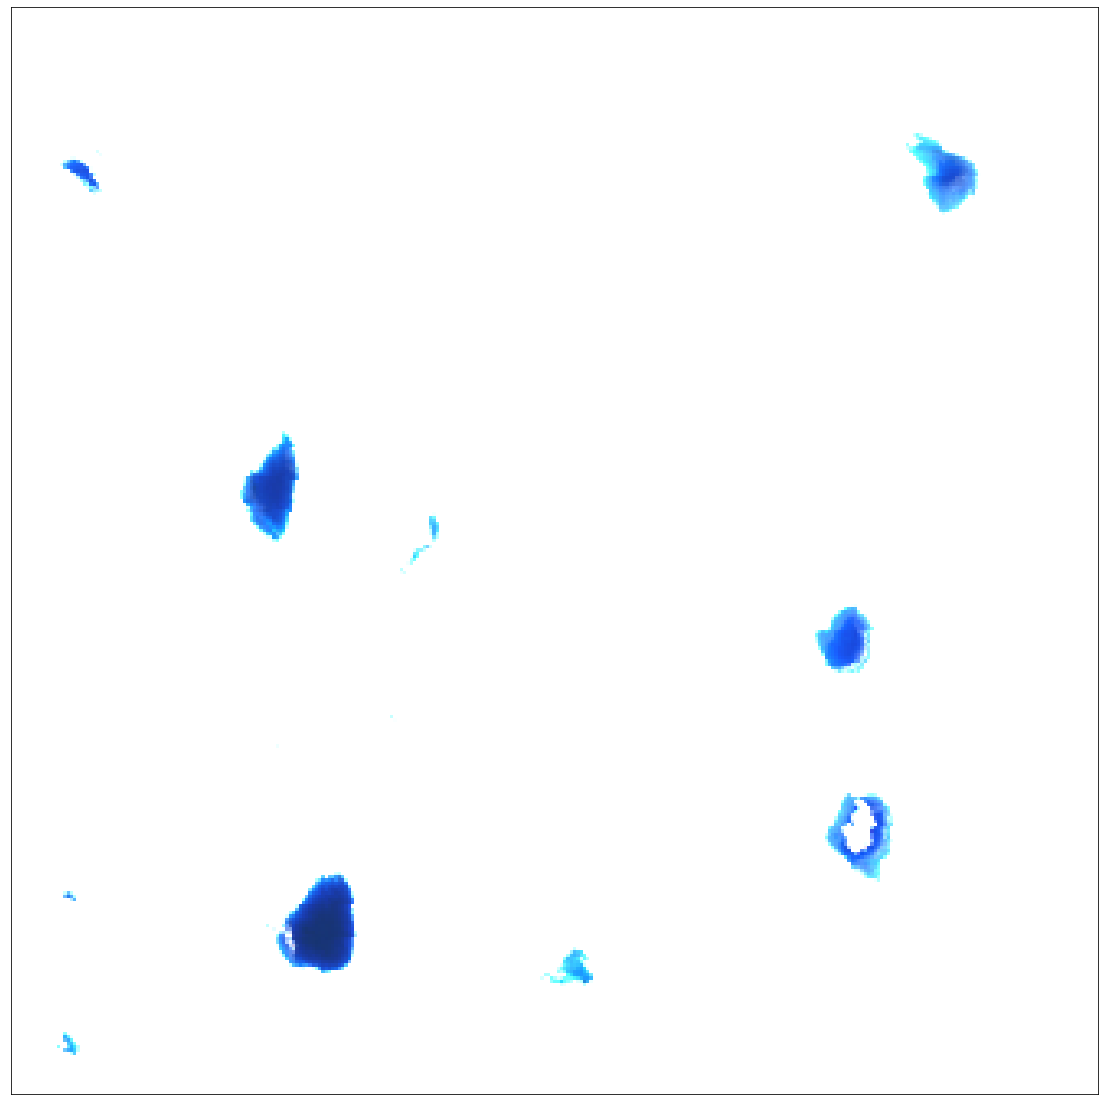

In [37]:
plot_utils.plot_RGB_LANDSAT_8_image(exemplary_landsat, datetime_idx=10)

2018-07-06 23:54:02


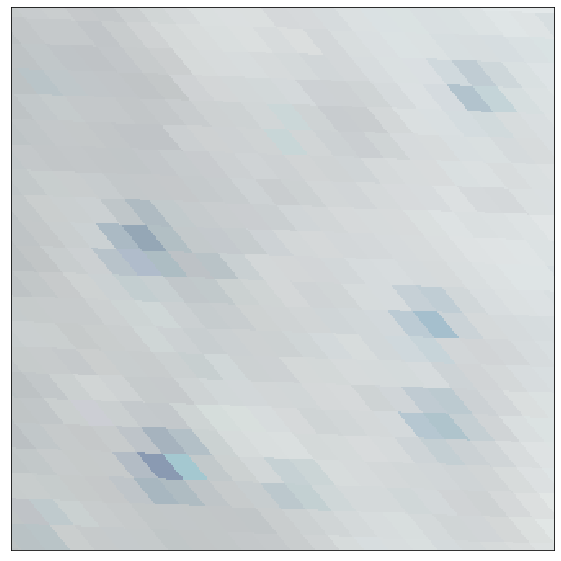

In [40]:
plot_utils.plot_RGB_MODIS_image(exemplary_landsat, data_acces_name='MODIS_RAW_BANDS_DAY_0', datetime_idx=10)

2018-07-06 23:54:02


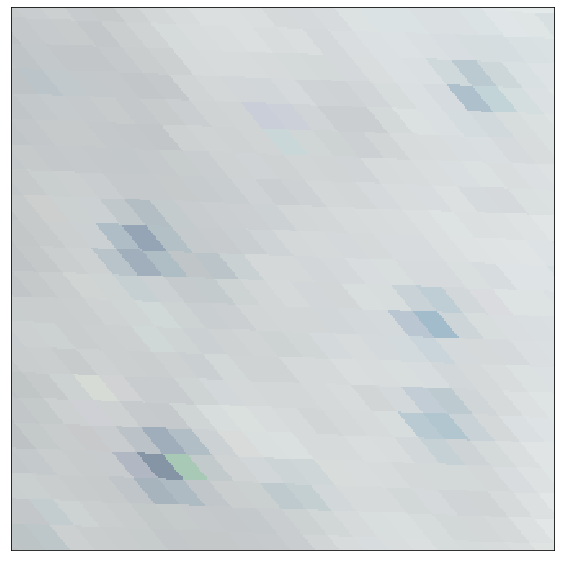

In [41]:
plot_utils.plot_RGB_MODIS_image(exemplary_landsat, data_acces_name='MODIS_RAW_BANDS_DAY_BEFORE', datetime_idx=10)

2018-07-06 23:54:02


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


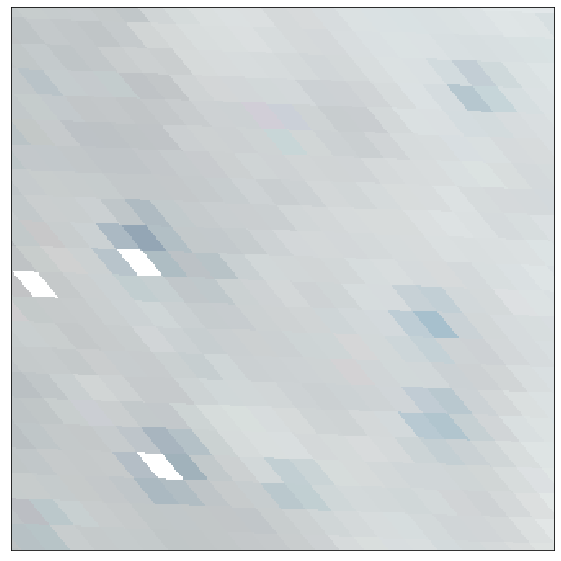

In [42]:
plot_utils.plot_RGB_MODIS_image(exemplary_landsat, data_acces_name='MODIS_RAW_BANDS_DAY_AFTER', datetime_idx=10)

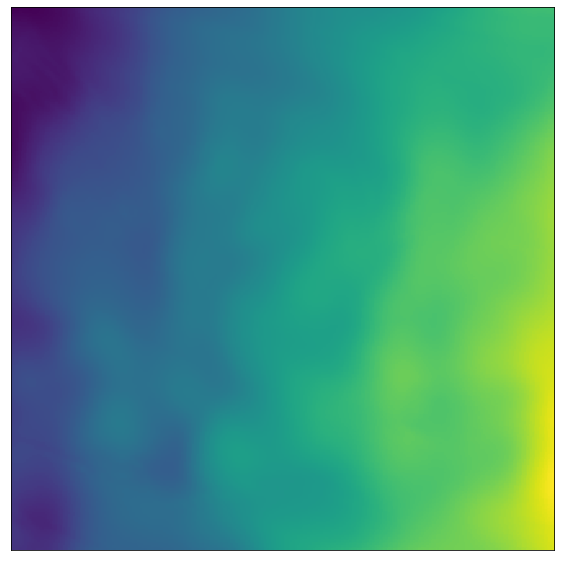

In [44]:
plot_utils.plot_timeless_mask_LANDSAT_8(exemplary_landsat, band_idx=0)

2018-07-06 23:54:02


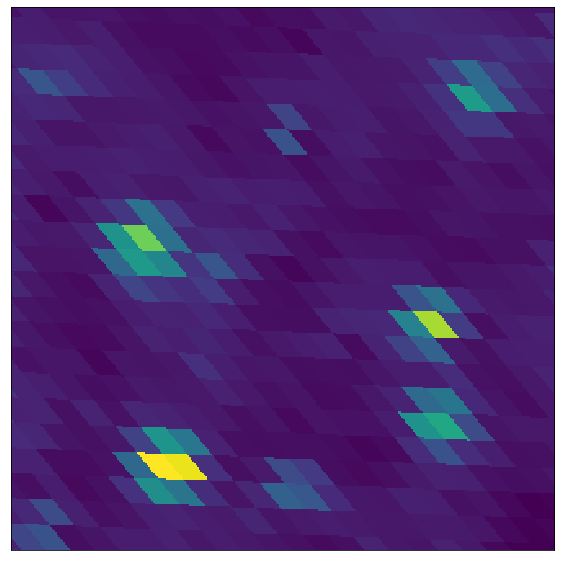

In [45]:
plot_utils.plot_single_band_LANDSAT_8(exemplary_landsat, band_idx=0, data_acces_name='MODIS_NRB' , datetime_idx =10 )

2018-07-06 23:54:02


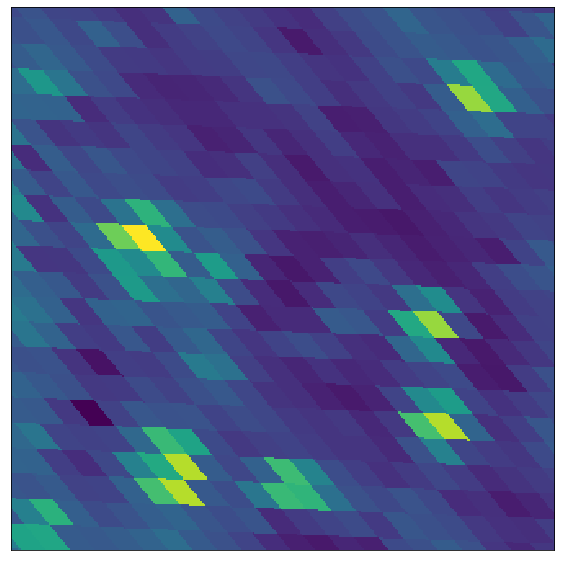

In [46]:
plot_utils.plot_single_band_LANDSAT_8(exemplary_landsat, band_idx=0, data_acces_name='MODIS_NDWI' , datetime_idx =10 )

2018-07-06 23:54:02


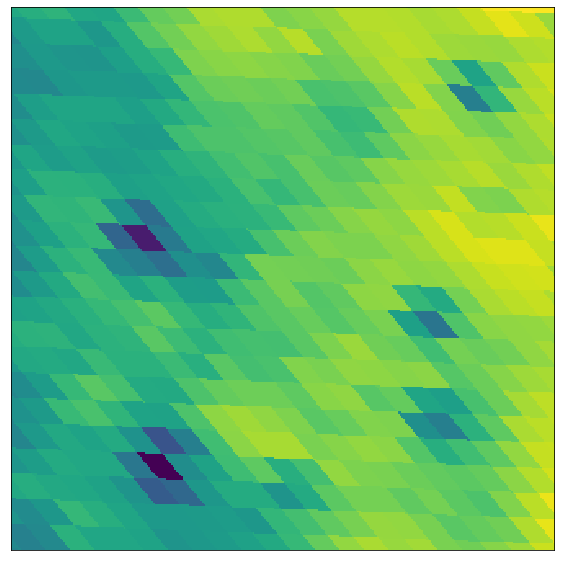

In [47]:
plot_utils.plot_single_band_LANDSAT_8(exemplary_landsat, band_idx=0, data_acces_name='MODIS_EUC_NORM_RAW_BANDS' , datetime_idx =10 ) 